In [78]:
import numpy as np

import dismech

b = 0.02
h = 0.001

geom = dismech.GeomParams(rod_r0=0.001,
                          shell_h=0,
                          axs=b*h,
                          ixs1=b*h**3/12,
                          ixs2=h*b**3/12,
                          jxs=b*h**3/6)

material = dismech.Material(density=1200,
                            youngs_rod=2e6,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

static_2d_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=5e-2,
                                  max_iter=25,
                                  total_time=10.0,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
#env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
#env.add_force('floorContact', ground_z=0, stiffness=1e3, delta=5e-3, h=1e-3)
#env.add_force('floorFriction', mu=0.75, vel_tol=1e-3)
env.add_force('viscous', ct=0.01, cn=0.1)
#env.set_static()   

geo = dismech.Geometry.from_txt('../tests/resources/rod_cantilever/horizontal_rod_n21.txt')

robot = dismech.SoftRobot(geom, material, geo, static_2d_sim, env)

In [79]:
stepper = dismech.ImplicitEulerTimeStepper(robot)

In [80]:
import numpy as np

def actuate_snake(robot, t):
    # --- Parameters you can tune ---
    amplitude = 0.02            # Max strain applied to each bend
    frequency = 2.0            # Oscillation frequency in Hz
    spatial_wavelength = 1.0   # Wavelength along the body in normalized units
    phase_offset = np.pi / 2   # Phase offset between vertical and tangential components

    # --- Compute strain pattern ---
    n_bends = robot.bend_springs.inc_strain.shape[0]
    s = np.linspace(0, 1, n_bends)  # Normalized position along body

    # Traveling sinusoidal waves for both vertical and tangential bending
    omega = 2 * np.pi * frequency
    k = 2 * np.pi / spatial_wavelength

    vertical_wave = amplitude * np.sin(omega * t - k * s)
    tangential_wave = amplitude * np.sin(omega * t - k * s + phase_offset)

    # Update robot bending strain (shape [n_bends, 2])
    #robot.bend_springs.inc_strain[:, 0] = vertical_wave     # normal bending
    robot.bend_springs.inc_strain[:, 1] = tangential_wave   # tangential bending

    return robot

stepper.before_step = actuate_snake
robots = stepper.simulate(robot)

qs = np.stack([robot.state.q for robot in robots])

In [81]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Snake')

fig = dismech.get_interactive_animation_plotly(robot, t, qs, options)
fig.show()

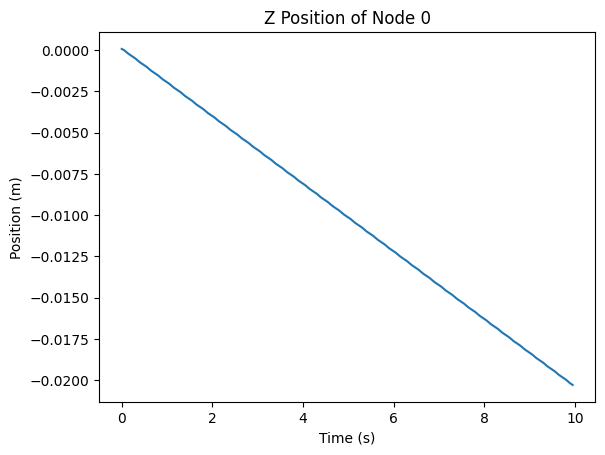

In [82]:
import matplotlib.pyplot as plt
plt.title("Z Position of Node 0")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.plot(t, qs[:, 0])
plt.show()